<h1> Scaling up ML using Cloud ML Engine </h1>

Adapted from [Notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/cloudmle/cloudmle.ipynb) of Google Coursera Course [Serverless Machine Learning with Tensorflow on Google Cloud Platform](https://www.coursera.org/learn/serverless-machine-learning-gcp/)

In [13]:
!pip install tensorflow==1.12

In [14]:
import tensorflow as tf
tf.__version__

'1.12.0'

In [15]:
import os
WORKINGDIR = os.getcwd()
folders = WORKINGDIR.split('/')
if folders.pop() == 'notebook':  # or a list: in ['notebook', 'src', etc.]
  WORKINGDIR = '/'.join(folders)
  print("New working directory: {}".format(WORKINGDIR))
else:
  print("Current Working direcotory is kept: {}".format(WORKINGDIR))
os.chdir(WORKINGDIR)

Current Working direcotory is kept: /content/datalab/proj_DL_models_and_pipelines_with_GCP


<h2> Environment variables for project and bucket </h2>

Note that:
<ol>
<li> Your project id is the *unique* string that identifies your project (not the project name). You can find this from the GCP Console dashboard's Home page.  My dashboard reads:  <b>Project ID:</b> cloud-training-demos </li>
<li> Cloud training often involves saving and restoring model files. If you don't have a bucket already, I suggest that you create one from the GCP console (because it will dynamically check whether the bucket name you want is available). A common pattern is to prefix the bucket name by the project id, so that it is unique. Also, for cost reasons, you might want to use a single region bucket. </li>
</ol>

<b>Add all detail in to [config.yaml](../config.yaml) file in main directory. Missing in public repository.


In [16]:
import yaml

with open("config.yaml", "r", encoding = "utf8") as f:
    config = yaml.load(f)
    
print(config)

# # #Create config manually and save as yaml:
# config = {}
# config['project-id'] = 'PROJECT'  # # REPLACE WITH YOUR PROJECT ID
# config['region'] = 'europe-west1' # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.
# config['bucket'] = 'Bucket-name'  # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
# 
# with open("../config_from_python.yaml", 'wb', encoding= 'utf8') as f:
#     yaml.dump(f)

{'tf-version': 1.12, 'project-id': 'ml-productive-pipeline-53122', 'bucket': 'ml-productive-pipeline-53122', 'region': 'europe-west1'}


In [17]:
import os
PROJECT = config['project-id'] 
REGION = config['region'] # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.
BUCKET = config['bucket'] # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.

In [18]:
# for bash
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = str(config['tf-version'])  # Tensorflow version 1.4 before

In [19]:
%bash
echo $TFVERSION

1.12


In [20]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


Allow the Cloud ML Engine service account to read/write to the bucket containing training data.

In [ ]:
%bash
PROJECT_ID=$PROJECT
AUTH_TOKEN=$(gcloud auth print-access-token)
# echo $AUTH_TOKEN
SVC_ACCOUNT=$(curl -X GET -H "Content-Type: application/json" \
    -H "Authorization: Bearer $AUTH_TOKEN" \
    https://ml.googleapis.com/v1/projects/${PROJECT_ID}:getConfig \
    | python -c "import json; import sys; response = json.load(sys.stdin); \
    print(response['serviceAccount'])")
echo "Current Service Account of VM: $SVC_ACCOUNT"
echo "Authorizing the Cloud ML Service account $SVC_ACCOUNT to access files in Bucket: $BUCKET"
gsutil -m defacl ch -u $SVC_ACCOUNT:R gs://$BUCKET
gsutil -m acl ch -u $SVC_ACCOUNT:R -r gs://$BUCKET  # error message (if bucket is empty) can be ignored
gsutil -m acl ch -u $SVC_ACCOUNT:W gs://$BUCKET

<h2> Packaging up the code </h2>

Take your code and put into a standard Python package structure, see  <a href="package_ml_engine/mnist_ml_engine.py">model.py</a>

In [49]:
!cat src/package_ml_engine/mnist_ml_engine.py

"""
First try to start Cloud ML

References:
Basic reference for packaging the model so that ml-engine can use it:
- https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/machine_learning/cloudmle/taxifare
MNIST-Estimator-Example:
- https://codeburst.io/use-tensorflow-dnnclassifier-estimator-to-classify-mnist-dataset-a7222bf9f940

ipython -i -m src.models.test_model_estimator_api.mnist_ml_engine -- --data_path=data --output_dir=src\models\test_model_estimator_api\trained --train_steps=100
"""
import os
import argparse
import json

import tensorflow as tf
import numpy as np
import shutil

from package_ml_engine.utils import load_data

###############################################################################
#Factor into config:
N_PIXEL = 784
OUTDIR = 'trained'
USE_TPU = False
EPOCHS = 10

if USE_TPU:
    _device_update = 'tpu'
else:
    _device_update = 'cpu'

IMAGE_SIZE = 28 * 28
NUM_LABELS = 10
BATCH_SIZE = 128
#########################################

<h2> Find absolute paths to your data </h2>

Note the absolute paths below. /content is mapped in Datalab to where the home icon takes you

In [24]:
%bash
echo $PWD
rm -rf $PWD/src/package_ml_engine/trained/

/content/datalab/proj_DL_models_and_pipelines_with_GCP


<h2> Running the Python module from the command-line </h2>

In [26]:
%bash
# rm -rf package_ml_engine.tar.gz ${PWD}/package_ml_engine/trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/../
python -m src.package_ml_engine.mnist_ml_engine \
   --data_path="${PWD}/data" \
   --output_dir=${PWD}/src/package_ml_engine/trained \
   --train_steps=100 \
   --job_dir=./tmp

['dnn/head/beta1_power', 'dnn/head/beta2_power', 'dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adam', 'dnn/hiddenlayer_0/bias/t_0/Adam_1', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adam', 'dnn/hiddenlayer_0/kernel/t_0/Adam_1', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adam', 'dnn/hiddenlayer_1/bias/t_0/Adam_1', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adam', 'dnn/hiddenlayer_1/kernel/t_0/Adam_1', 'dnn/hiddenlayer_2/bias', 'dnn/hiddenlayer_2/bias/t_0/Adam', 'dnn/hiddenlayer_2/bias/t_0/Adam_1', 'dnn/hiddenlayer_2/kernel', 'dnn/hiddenlayer_2/kernel/t_0/Adam', 'dnn/hiddenlayer_2/kernel/t_0/Adam_1', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adam', 'dnn/logits/bias/t_0/Adam_1', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adam', 'dnn/logits/kernel/t_0/Adam_1', 'global_step']


/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
2019-02-12 16:23:43.305371: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.


In [27]:
%bash
ls $PWD/src/package_ml_engine/trained/export/exporter/

1549988626


Create an test-image in numpy format saved as json (copy from test set)

In [28]:
%writefile data/test.json
{"x": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3294117748737335, 0.7254902124404907, 0.6235294342041016, 0.5921568870544434, 0.23529411852359772, 0.1411764770746231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8705882430076599, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9450980424880981, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.6666666865348816, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26274511218070984, 0.4470588266849518, 0.2823529541492462, 0.4470588266849518, 0.6392157077789307, 0.8901960849761963, 0.9960784316062927, 0.8823529481887817, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9803921580314636, 0.8980392217636108, 0.9960784316062927, 0.9960784316062927, 0.5490196347236633, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666667014360428, 0.25882354378700256, 0.054901961237192154, 0.26274511218070984, 0.26274511218070984, 0.26274511218070984, 0.23137255012989044, 0.08235294371843338, 0.9254902005195618, 0.9960784316062927, 0.4156862795352936, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32549020648002625, 0.9921568632125854, 0.8196078538894653, 0.07058823853731155, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08627451211214066, 0.9137254953384399, 1.0, 0.32549020648002625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5058823823928833, 0.9960784316062927, 0.9333333373069763, 0.1725490242242813, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23137255012989044, 0.9764705896377563, 0.9960784316062927, 0.24313725531101227, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686559677124, 0.9960784316062927, 0.7333333492279053, 0.019607843831181526, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411926865578, 0.8039215803146362, 0.9725490212440491, 0.22745098173618317, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4941176474094391, 0.9960784316062927, 0.7137255072593689, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29411765933036804, 0.9843137264251709, 0.9411764740943909, 0.2235294133424759, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07450980693101883, 0.8666666746139526, 0.9960784316062927, 0.6509804129600525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0117647061124444, 0.7960784435272217, 0.9960784316062927, 0.8588235378265381, 0.13725490868091583, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14901961386203766, 0.9960784316062927, 0.9960784316062927, 0.3019607961177826, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12156862765550613, 0.8784313797950745, 0.9960784316062927, 0.45098039507865906, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686559677124, 0.9960784316062927, 0.9960784316062927, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.239215686917305, 0.9490196108818054, 0.9960784316062927, 0.9960784316062927, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098054409027, 0.9960784316062927, 0.9960784316062927, 0.8588235378265381, 0.1568627506494522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098054409027, 0.9960784316062927, 0.8117647171020508, 0.07058823853731155, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

Writing data/test.json


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


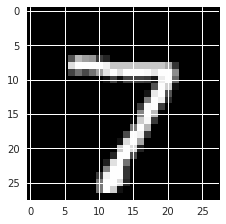

In [30]:
from matplotlib import pyplot as plt
import numpy as np
image = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3294117748737335, 0.7254902124404907, 0.6235294342041016, 0.5921568870544434, 0.23529411852359772, 0.1411764770746231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8705882430076599, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9450980424880981, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.6666666865348816, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26274511218070984, 0.4470588266849518, 0.2823529541492462, 0.4470588266849518, 0.6392157077789307, 0.8901960849761963, 0.9960784316062927, 0.8823529481887817, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9803921580314636, 0.8980392217636108, 0.9960784316062927, 0.9960784316062927, 0.5490196347236633, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666667014360428, 0.25882354378700256, 0.054901961237192154, 0.26274511218070984, 0.26274511218070984, 0.26274511218070984, 0.23137255012989044, 0.08235294371843338, 0.9254902005195618, 0.9960784316062927, 0.4156862795352936, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32549020648002625, 0.9921568632125854, 0.8196078538894653, 0.07058823853731155, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08627451211214066, 0.9137254953384399, 1.0, 0.32549020648002625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5058823823928833, 0.9960784316062927, 0.9333333373069763, 0.1725490242242813, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23137255012989044, 0.9764705896377563, 0.9960784316062927, 0.24313725531101227, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686559677124, 0.9960784316062927, 0.7333333492279053, 0.019607843831181526, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411926865578, 0.8039215803146362, 0.9725490212440491, 0.22745098173618317, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4941176474094391, 0.9960784316062927, 0.7137255072593689, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29411765933036804, 0.9843137264251709, 0.9411764740943909, 0.2235294133424759, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07450980693101883, 0.8666666746139526, 0.9960784316062927, 0.6509804129600525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0117647061124444, 0.7960784435272217, 0.9960784316062927, 0.8588235378265381, 0.13725490868091583, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14901961386203766, 0.9960784316062927, 0.9960784316062927, 0.3019607961177826, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12156862765550613, 0.8784313797950745, 0.9960784316062927, 0.45098039507865906, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686559677124, 0.9960784316062927, 0.9960784316062927, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.239215686917305, 0.9490196108818054, 0.9960784316062927, 0.9960784316062927, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098054409027, 0.9960784316062927, 0.9960784316062927, 0.8588235378265381, 0.1568627506494522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098054409027, 0.9960784316062927, 0.8117647171020508, 0.07058823853731155, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
plt.figure(figsize=(20,4))
plt.subplot(1, 5, 1)
plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)

In order to work with Python 3, delete the `*.pyc` files, see [post](https://stackoverflow.com/questions/48824381/gcloud-ml-engine-local-predict-runtimeerror-bad-magic-number-in-pyc-file)

In [39]:
%bash
#remove any pyc files: Using Python3 you have to recompile
rm /tools/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc
## local predict doesn't work with Python 3 yet
model_dir=$(ls $PWD/src/package_ml_engine/trained/export/exporter/)
echo "Selected Model:  $model_dir"
gcloud ml-engine local predict \
    --model-dir=${PWD}/src/package_ml_engine/trained/export/exporter/${model_dir} \
    --json-instances=./data/test.json \
    --verbosity debug

Selected Model:  1549988626
CLASS_IDS  CLASSES  LOGITS                                                                                                                                                                                                                           PROBABILITIES
[7]        [u'7']   [-0.10308753699064255, 0.0027766134589910507, 0.008046627044677734, -0.062273938208818436, -0.021005088463425636, -0.010045293718576431, -0.0804160013794899, 0.05865110456943512, -0.030750004574656487, 0.005777463316917419]  [0.0922301635146141, 0.10252958536148071, 0.10307133942842484, 0.09607227891683578, 0.10012001544237137, 0.10122334957122803, 0.09434504061937332, 0.1084214374423027, 0.09914910048246384, 0.10283771902322769]


DEBUG: Running [gcloud.ml-engine.local.predict] with arguments: [--json-instances: "./data/test.json", --model-dir: "/content/datalab/proj_DL_models_and_pipelines_with_GCP/src/package_ml_engine/trained/export/exporter/1549988626", --verbosity: "debug"]
/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

INFO: Display format: "default 
          table(
              predictions:format="table(
                  class_ids, classes, logits, probabilities
              )"
          )"


In [38]:
%bash
gcloud ml-engine local predict --help

NAME
    gcloud ml-engine local predict - run prediction locally

SYNOPSIS
    gcloud ml-engine local predict --model-dir=MODEL_DIR
        (--json-instances=JSON_INSTANCES | --text-instances=TEXT_INSTANCES)
        [--framework=FRAMEWORK] [--signature-name=SIGNATURE_NAME]
        [GCLOUD_WIDE_FLAG ...]

DESCRIPTION
    gcloud ml-engine local predict performs prediction locally with the given
    instances. It requires the TensorFlow SDK be installed locally. The output
    format mirrors gcloud ml-engine predict (online prediction)

REQUIRED FLAGS
     --model-dir=MODEL_DIR
        Path to the model.

     Exactly one of these must be specified:

       --json-instances=JSON_INSTANCES
          Path to a local file from which instances are read. Instances are in
          JSON format; newline delimited.

          An example of the JSON instances file:

              {"images": [0.0, ..., 0.1], "key": 3}
              {"images": [0.0, ..., 0.1], "key": 2}
              ...

          

<h2> Running locally using gcloud </h2>

In [50]:
%bash
# rm -rf taxifare.tar.gz taxi_trained
gcloud ml-engine local train \
   --module-name=package_ml_engine.mnist_ml_engine \
   --package-path=${PWD}/src/package_ml_engine \
   -- \
   --data_path="${PWD}/data" \
   --output_dir=${PWD}/src/package_ml_engine/trained \
   --train_steps=500 --job_dir=./tmp

['dnn/head/beta1_power', 'dnn/head/beta2_power', 'dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adam', 'dnn/hiddenlayer_0/bias/t_0/Adam_1', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adam', 'dnn/hiddenlayer_0/kernel/t_0/Adam_1', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adam', 'dnn/hiddenlayer_1/bias/t_0/Adam_1', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adam', 'dnn/hiddenlayer_1/kernel/t_0/Adam_1', 'dnn/hiddenlayer_2/bias', 'dnn/hiddenlayer_2/bias/t_0/Adam', 'dnn/hiddenlayer_2/bias/t_0/Adam_1', 'dnn/hiddenlayer_2/kernel', 'dnn/hiddenlayer_2/kernel/t_0/Adam', 'dnn/hiddenlayer_2/kernel/t_0/Adam_1', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adam', 'dnn/logits/bias/t_0/Adam_1', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adam', 'dnn/logits/kernel/t_0/Adam_1', 'global_step']


/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
2019-02-12 16:52:26.726367: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.


### Visualise in TensorBoard

In [51]:
from google.datalab.ml import TensorBoard
TensorBoard().start('{}/package_ml_engine'.format(os.environ['PWD']))

TensorBoard was started successfully with pid 21331. Click here to access it.

21331

In [52]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

Stopped TensorBoard with pid 21331


If the above step (to stop TensorBoard) appears stalled, just move on to the next step. You don't need to wait for it to return.

<h2> Submit training job using gcloud </h2>

First copy the training data to the cloud.  Then, launch a training job.

After you submit the job, go to the cloud console (http://console.cloud.google.com) and select <b>Machine Learning | Jobs</b> to monitor progress.  

<b>Note:</b> Don't be concerned if the notebook stalls (with a blue progress bar) or returns with an error about being unable to refresh auth tokens. This is a long-lived Cloud job and work is going on in the cloud.  Use the Cloud Console link (above) to monitor the job.

In [53]:
%bash
echo $BUCKET
gsutil -m rm -rf gs://${BUCKET}/mnist_ml_engine/*
gsutil -m cp ${PWD}/data/mnist.npy gs://${BUCKET}/mnist_ml_engine/

ml-productive-pipeline-53122


Removing gs://ml-productive-pipeline-53122/mnist_ml_engine/trained/events.out.tfevents.1549974153.cmle-training-505476338828803528#1549974256031230...
Removing gs://ml-productive-pipeline-53122/mnist_ml_engine/trained/eval/events.out.tfevents.1549974268.cmle-training-15082098775152679328#1549974271462754...
Removing gs://ml-productive-pipeline-53122/mnist_ml_engine/mnist.npy#1549974086409959...
Removing gs://ml-productive-pipeline-53122/mnist_ml_engine/trained/events.out.tfevents.1549974187.cmle-training-15082098775152679328#1549974293778942...
Removing gs://ml-productive-pipeline-53122/mnist_ml_engine/trained/#1549974255433761...
Removing gs://ml-productive-pipeline-53122/mnist_ml_engine/trained/checkpoint#1549974262145941...
Removing gs://ml-productive-pipeline-53122/mnist_ml_engine/trained/eval/#1549974230359914...
Removing gs://ml-productive-pipeline-53122/mnist_ml_engine/trained/export/exporter/#1549974236015403...
Removing gs://ml-productive-pipeline-53122/mnist_ml_engine/trained

In [54]:
steps = 10000
batch_size = 128
n_train = 60000
print("Number of epochs using {} steps: {:.1f}".format(steps, steps * batch_size / n_train))
steps = int(60000 / 128 * 10) + 1
print("For ten epochs specify {} steps".format(steps))

Number of epochs using 10000 steps: 21.3
For ten epochs specify 4688 steps


In [55]:
%%bash
OUTDIR=gs://${BUCKET}/mnist_ml_engine/trained
JOBNAME=mnist_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=src.package_ml_engine.mnist_ml_engine \
   --package-path=${PWD}/src/package_ml_engine \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC \
   --python-version 3.5 \
   --runtime-version=$TFVERSION \
   -- \
   --data_path="gs://${BUCKET}/mnist_ml_engine/" \
   --output_dir=$OUTDIR \
   --train_steps=5000 \
   --job_dir=$OUTDIR/jobs 

gs://ml-productive-pipeline-53122/mnist_ml_engine/trained europe-west1 mnist_190212_165517
jobId: mnist_190212_165517
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [mnist_190212_165517] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe mnist_190212_165517

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs mnist_190212_165517


In [ ]:
%%bash
gcloud ml-engine jobs stream-logs mnist_190212_122128

Don't be concerned if the notebook appears stalled (with a blue progress bar) or returns with an error about being unable to refresh auth tokens. This is a long-lived Cloud job and work is going on in the cloud. 

<b>Use the Cloud Console link to monitor the job and do NOT proceed until the job is done.</b>

<h2> Deploy model </h2>

Find out the actual name of the subdirectory where the model is stored and use it to deploy the model.  Deploying model will take up to <b>5 minutes</b>.

In [56]:
%bash
gsutil ls gs://${BUCKET}/mnist_ml_engine/trained/export/exporter

CommandException: One or more URLs matched no objects.


In [13]:
%bash
MODEL_NAME="MNIST_MLENGINE"
MODEL_VERSION="v1"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/mnist_ml_engine/trained/export/exporter | tail -1)
echo "Run these commands one-by-one (the very first time, you'll create a model and then create a version)"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models   create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version $TFVERSION

Run these commands one-by-one (the very first time, you'll create a model and then create a version)


ERROR: (gcloud.ml-engine.models.create) Resource in project [ml-productive-pipeline-53122] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name
Creating version (this might take a few minutes)......
..................................................................................................done.


<h2> Prediction </h2>

In [10]:
%bash
gcloud ml-engine predict --model=MNIST_MLENGINE --version=v1 --json-instances=data/test.json

CLASS_IDS  CLASSES  LOGITS                                                                                                                                                                                                             PROBABILITIES
[8]        [u'8']   [0.21754291653633118, -0.27428337931632996, 0.3757272958755493, 0.29848191142082214, 0.20440849661827087, 0.10437262058258057, -0.12558713555335999, -0.11994972825050354, 2.0027101039886475, 0.970148503780365]  [0.06555937975645065, 0.04009012132883072, 0.07679508626461029, 0.0710863471031189, 0.06470392644405365, 0.05854443088173866, 0.04651738330721855, 0.046780362725257874, 0.39077168703079224, 0.13915131986141205]


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


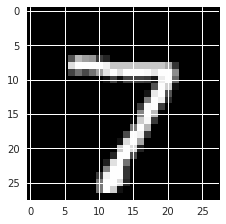

In [48]:
from matplotlib import pyplot as plt
import numpy as np
with open("data/test.json", "r") as f:
  image = json.load(f)
image = np.array(image['x'])
plt.figure(figsize=(20,4))
plt.subplot(1, 5, 1)
plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)

Get predictions using the [Python-Client-Library, see Tutorial](https://cloud.google.com/ml-engine/docs/tensorflow/python-client-library). Since we have created and deployed a model already, we use the [`predict`](https://cloud.google.com/ml-engine/reference/rest/v1/projects) Method instead of `create` as in the documentation. 

[API-Reference](https://cloud.google.com/ml-engine/reference/rest/)

In [11]:
%bash
export GOOGLE_APPLICATION_CREDENTIALS=$PWD/ML-productive-pipeline-53122-64d3c31786e7.json
echo $GOOGLE_APPLICATION_CREDENTIALS

/content/datalab/proj_DL_models_and_pipelines_with_GCP/notebook/ML-productive-pipeline-53122-64d3c31786e7.json


In [49]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/datalab/proj_DL_models_and_pipelines_with_GCP/notebook/../ML-productive-pipeline-53122-64d3c31786e7.json'

In [13]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors
import json

```
Signature: discovery.build(serviceName, version, http=None, discoveryServiceUrl='https://www.googleapis.com/discovery/v1/apis/{api}/{apiVersion}/rest', developerKey=None, model=None, requestBuilder=<class 'googleapiclient.http.HttpRequest'>, credentials=None, cache_discovery=True, cache=None)
Docstring:
Construct a Resource for interacting with an API.

Construct a Resource object for interacting with an API. The serviceName and
version are the names from the Discovery service.

Args:
serviceName: string, name of the service.
version: string, the version of the service.
http: httplib2.Http, An instance of httplib2.Http or something that acts
like it that HTTP requests will be made through.
discoveryServiceUrl: string, a URI Template that points to the location of
the discovery service. It should have two parameters {api} and
{apiVersion} that when filled in produce an absolute URI to the discovery
document for that service.
developerKey: string, key obtained from
https://code.google.com/apis/console.
model: googleapiclient.Model, converts to and from the wire format.
requestBuilder: googleapiclient.http.HttpRequest, encapsulator for an HTTP
request.
credentials: oauth2client.Credentials or
google.auth.credentials.Credentials, credentials to be used for
authentication.
cache_discovery: Boolean, whether or not to cache the discovery doc.
cache: googleapiclient.discovery_cache.base.CacheBase, an optional
cache object for the discovery documents.

Returns:
A Resource object with methods for interacting with the service.
File: /usr/local/envs/py3env/lib/python3.5/site-packages/googleapiclient/discovery.py
Type: function
```

In [14]:
api = discovery.build(serviceName='ml', version='v1',
                      http=None, 
                      discoveryServiceUrl='https://www.googleapis.com/discovery/v1/apis/{api}/{apiVersion}/rest', 
                      developerKey=None, 
                      model=None, 
                      #requestBuilder=<class 'googleapiclient.http.HttpRequest'>, 
                      credentials=None, 
                      cache_discovery=True, 
                      cache=None)

In [53]:
print(dir(api))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_basic_methods', '_add_nested_resources', '_add_next_methods', '_baseUrl', '_developerKey', '_dynamic_attrs', '_http', '_model', '_requestBuilder', '_resourceDesc', '_rootDesc', '_schema', '_set_dynamic_attr', '_set_service_methods', 'new_batch_http_request', 'operations', 'projects']


In [15]:
MODEL_NAME = 'MNIST_MLENGINE'
VERSION = 'v1'

In [17]:
project_id = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, VERSION)
request_data = {"instances":
  [
   {"x": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3294117748737335, 0.7254902124404907, 0.6235294342041016, 0.5921568870544434, 0.23529411852359772, 0.1411764770746231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8705882430076599, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9450980424880981, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.6666666865348816, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26274511218070984, 0.4470588266849518, 0.2823529541492462, 0.4470588266849518, 0.6392157077789307, 0.8901960849761963, 0.9960784316062927, 0.8823529481887817, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9803921580314636, 0.8980392217636108, 0.9960784316062927, 0.9960784316062927, 0.5490196347236633, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666667014360428, 0.25882354378700256, 0.054901961237192154, 0.26274511218070984, 0.26274511218070984, 0.26274511218070984, 0.23137255012989044, 0.08235294371843338, 0.9254902005195618, 0.9960784316062927, 0.4156862795352936, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32549020648002625, 0.9921568632125854, 0.8196078538894653, 0.07058823853731155, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08627451211214066, 0.9137254953384399, 1.0, 0.32549020648002625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5058823823928833, 0.9960784316062927, 0.9333333373069763, 0.1725490242242813, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23137255012989044, 0.9764705896377563, 0.9960784316062927, 0.24313725531101227, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686559677124, 0.9960784316062927, 0.7333333492279053, 0.019607843831181526, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411926865578, 0.8039215803146362, 0.9725490212440491, 0.22745098173618317, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4941176474094391, 0.9960784316062927, 0.7137255072593689, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29411765933036804, 0.9843137264251709, 0.9411764740943909, 0.2235294133424759, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07450980693101883, 0.8666666746139526, 0.9960784316062927, 0.6509804129600525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0117647061124444, 0.7960784435272217, 0.9960784316062927, 0.8588235378265381, 0.13725490868091583, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14901961386203766, 0.9960784316062927, 0.9960784316062927, 0.3019607961177826, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12156862765550613, 0.8784313797950745, 0.9960784316062927, 0.45098039507865906, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686559677124, 0.9960784316062927, 0.9960784316062927, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.239215686917305, 0.9490196108818054, 0.9960784316062927, 0.9960784316062927, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098054409027, 0.9960784316062927, 0.9960784316062927, 0.8588235378265381, 0.1568627506494522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098054409027, 0.9960784316062927, 0.8117647171020508, 0.07058823853731155, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
  ]
}
request = api.projects().predict(body=request_data, name=project_id).execute()
print(request)

{'predictions': [{'logits': [0.21754291653633118, -0.27428337931632996, 0.3757272958755493, 0.29848191142082214, 0.20440849661827087, 0.10437262058258057, -0.12558713555335999, -0.11994972825050354, 2.0027101039886475, 0.970148503780365], 'classes': ['8'], 'probabilities': [0.06555937975645065, 0.04009012132883072, 0.07679508626461029, 0.0710863471031189, 0.06470392644405365, 0.05854443088173866, 0.04651738330721855, 0.046780362725257874, 0.39077168703079224, 0.13915131986141205], 'class_ids': [8]}]}


<h2> Train on larger dataset </h2>

I have already followed the steps below and the files are already available. <b> You don't need to do the steps in this comment. </b> In the next chapter (on feature engineering), we will avoid all this manual processing by using Cloud Dataflow.

Go to http://bigquery.cloud.google.com/ and type the query:
<pre>
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  'nokeyindata' AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  AND ABS(HASH(pickup_datetime)) % 1000 == 1
</pre>

Note that this is now 1,000,000 rows (i.e. 100x the original dataset).  Export this to CSV using the following steps (Note that <b>I have already done this and made the resulting GCS data publicly available</b>, so you don't need to do it.):
<ol>
<li> Click on the "Save As Table" button and note down the name of the dataset and table.
<li> On the BigQuery console, find the newly exported table in the left-hand-side menu, and click on the name.
<li> Click on "Export Table"
<li> Supply your bucket name and give it the name train.csv (for example: gs://cloud-training-demos-ml/taxifare/ch3/train.csv). Note down what this is.  Wait for the job to finish (look at the "Job History" on the left-hand-side menu)
<li> In the query above, change the final "== 1" to "== 2" and export this to Cloud Storage as valid.csv (e.g.  gs://cloud-training-demos-ml/taxifare/ch3/valid.csv)
<li> Download the two files, remove the header line and upload it back to GCS.
</ol>

<p/>
<p/>

<h2> Run Cloud training on 1-million row dataset </h2>

This took 60 minutes and uses as input 1-million rows.  The model is exactly the same as above. The only changes are to the input (to use the larger dataset) and to the Cloud MLE tier (to use STANDARD_1 instead of BASIC -- STANDARD_1 is approximately 10x more powerful than BASIC).  At the end of the training the loss was 32, but the RMSE (calculated on the validation dataset) was stubbornly at 9.03. So, simply adding more data doesn't help.

In [ ]:
%%bash

XXXXX  this takes 60 minutes. if you are sure you want to run it, then remove this line.

OUTDIR=gs://${BUCKET}/taxifare/ch3/taxi_trained
JOBNAME=lab3a_$(date -u +%y%m%d_%H%M%S)
CRS_BUCKET=cloud-training-demos # use the already exported data
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=STANDARD_1 \
   --runtime-version=$TFVERSION \
   -- \
   --train_data_paths="gs://${CRS_BUCKET}/taxifare/ch3/train.csv" \
   --eval_data_paths="gs://${CRS_BUCKET}/taxifare/ch3/valid.csv"  \
   --output_dir=$OUTDIR \
   --train_steps=100000

Copyright 2016 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License